# AC-06 Customer Segmentation for Personalized Retail Marketing
## ID Tim Capstone : A25-CS248
### M891D5Y1037 M. Ryan Rifqi Firdaus - M891D5Y1037@student.devacademy.id
### M891D5X1507 Nida Rofi'Ah Hassan - M891D5X1507@student.devacademy.id
### M891D5Y0577 Fajar Agus Dwi Rahmawan - M891D5Y0577@student.devacademy.id

# Import Library

In [355]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from google.colab import files
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

sns.set(style="whitegrid")

In [356]:
# files.upload()

# # Step 1: Setup environment
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Step 2: Download dataset dari Kaggle
# !kaggle datasets download -d utkalk/large-retail-data-set-for-eda

# # Step 3: Ekstrak file ZIP
# !unzip -q large-retail-data-set-for-eda.zip

# # Step 4: Cek isi folder untuk melihat nama file CSV
# !ls

# Data Preparation

In [357]:
# Ganti nama file jika berbeda setelah unzip
df = pd.read_csv("retail_data.csv")

# Ambil 10.000 baris pertama agar lebih ringan
df = df.head(10000)

# Lihat 5 baris pertama
df.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,occupation,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,transaction_hour,day_of_week,week_of_year,month_of_year,avg_purchase_value,purchase_frequency,last_purchase_date,avg_discount_used,preferred_store,online_purchases,in_store_purchases,avg_items_per_transaction,avg_transaction_value,total_returned_items,total_returned_value,total_sales,total_transactions,total_items_purchased,total_discounts_received,avg_spent_per_category,max_single_purchase_value,min_single_purchase_value,product_name,product_brand,product_rating,product_review_count,product_stock,product_return_rate,product_size,product_weight,product_color,product_material,product_manufacture_date,product_expiry_date,product_shelf_life,promotion_id,promotion_type,promotion_start_date,promotion_end_date,promotion_effectiveness,promotion_channel,promotion_target_audience,customer_zip_code,customer_city,customer_state,store_zip_code,store_city,store_state,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,Self-Employed,503290,2020-10-11 10:08:52,1480,Electronics,8,49.72,0.50,Credit Card,Location A,18,Wednesday,27,7,411.13,Weekly,2021-09-11 04:22:38,0.02,Location A,55,86,8.64,171.83,0,750.40,563.16,69,367,415.01,114.28,679.25,0.28,Product D,Brand Y,2.5,560,48,0.40,Small,4.61,Red,Metal,2019-08-04 01:47:01,2022-05-28 14:54:02,250,271,20% Off,2021-07-14 14:28:42,2022-12-30 13:04:13,High,Online,New Customers,37848,City D,State Y,88500,City D,State Y,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,Unemployed,347796,2021-12-08 01:07:40,1597,Groceries,7,817.76,0.32,Credit Card,Location C,15,Friday,20,2,268.71,Daily,2021-05-16 12:01:16,0.33,Location C,48,2,9.60,20.18,4,551.60,7554.57,8,475,801.79,305.95,491.56,4.65,Product C,Brand X,4.7,413,80,0.30,Medium,0.84,Blue,Metal,2019-10-23 19:59:17,2022-12-19 08:04:41,180,631,Flash Sale,2021-09-23 04:26:09,2022-09-13 03:16:26,Low,Social Media,New Customers,44896,City A,State X,30046,City C,State X,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,Self-Employed,493688,2020-02-17 09:40:48,5142,Toys,8,270.30,0.35,Debit Card,Location A,9,Saturday,35,6,246.79,Weekly,2021-02-07 16:47:48,0.47,Location B,16,45,1.55,55.17,0,629.19,7564.14,73,138,264.31,426.70,938.26,7.30,Product B,Brand X,4.6,312,14,0.08,Medium,0.23,Green,Plastic,2018-05-12 08:00:29,2023-02-01 12:15:07,131,879,Flash Sale,2021-06-13 12:31:15,2022-03-13 00:53:35,Low,Online,New Customers,11816,City B,State X,26169,City A,State Y,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61
3,4,32,Female,Low,No,0,No,Divorced,2,Master's,Employed,861348,2020-08-13 00:43:14,8447,Toys,2,547.84,0.10,Credit Card,Location A,13,Friday,42,8,178.92,Weekly,2021-12-30 23:48:26,0.41,Location B,50,47,1.78,15.79,3,346.67,8125.92,20,158,192.93,689.58,644.31,7.31,Product A,Brand Z,1.1,110,69,0.09,Large,4.37,Blue,Wood,2019-11-15 16:17:29,2023-02-05 11:46:57,16,211,Buy One Get One Free,2021-05-23 05:42:48,2022-02-06 00:42:30,High,Social Media,Returning Customers,78604,City A,State Y,22667,City B,State Z,50.43,Yes,Winter,No,12,No,Low,12,Low,42
4,5,60,Female,Low,Yes,7,Yes,Divorced,2,Bachelor's,Employed,535835,2021-07-02 11:59:03,6025,Clothing,4,785.29,0.17,Mobile Payment,Location C,17,Monday,37,3,214.06,Yearly,2021-11-02 11:48:25,0.22,Location B,48,42,9.38,240.03,2,979.91,114.32,83,263,497.26,715.86,162.86,1.92,Product C,Brand X,3.8,172,25,0.39,Small,1.68,Red,Metal,2019-08-27 02:58:19,2023-10-05 08:13:07,57,862,Flash Sale,2021-04-19 04:55:32,2022-12-04 13:07:09,Medium,Online,New Customers,17760,City B,State Z,87843,City C,State X,36.55,Yes,Summer,Yes,3,No,Medium,31,Low,242


In [358]:
df.shape

(10000, 78)

In [359]:
print("Nama kolom asli:", df.columns.tolist())

# Ubah ke lowercase, ganti spasi dgn underscore
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Hapus karakter aneh jika ada
df.columns = df.columns.str.replace('[^a-zA-Z0-9_]', '', regex=True)

print("\nNama kolom baru (dibersihkan):", df.columns.tolist())

Nama kolom asli: ['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program', 'membership_years', 'churned', 'marital_status', 'number_of_children', 'education_level', 'occupation', 'transaction_id', 'transaction_date', 'product_id', 'product_category', 'quantity', 'unit_price', 'discount_applied', 'payment_method', 'store_location', 'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year', 'avg_purchase_value', 'purchase_frequency', 'last_purchase_date', 'avg_discount_used', 'preferred_store', 'online_purchases', 'in_store_purchases', 'avg_items_per_transaction', 'avg_transaction_value', 'total_returned_items', 'total_returned_value', 'total_sales', 'total_transactions', 'total_items_purchased', 'total_discounts_received', 'avg_spent_per_category', 'max_single_purchase_value', 'min_single_purchase_value', 'product_name', 'product_brand', 'product_rating', 'product_review_count', 'product_stock', 'product_return_rate', 'product_size', 'product_weight', 'product_color

In [360]:
relevant_columns = [
    # Profil pelanggan
    'customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program', 'membership_years',

    # Transaksi
    'transaction_id', 'transaction_date', 'product_id', 'product_category',
    'quantity', 'unit_price', 'discount_applied', 'payment_method', 'store_location',

    # Metrik perilaku pelanggan
    'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
    'total_sales', 'total_transactions', 'total_items_purchased',
    'avg_transaction_value', 'online_purchases', 'in_store_purchases',
    'days_since_last_purchase', 'churned'
]

# Pastikan hanya kolom yang tersedia di dataset
available_cols = [col for col in relevant_columns if col in df.columns]
df = df[available_cols]

# Tampilkan hasil subset data
print(f"Jumlah kolom yang digunakan: {len(available_cols)}")
display(df.head())

Jumlah kolom yang digunakan: 26


,customer_id,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned
0,1,56,Other,High,No,0,503290,2020-10-11 10:08:52,1480,Electronics,8,49.72,0.50,Credit Card,Location A,411.13,Weekly,2021-09-11 04:22:38,563.16,69,367,171.83,55,86,40,No
1,2,69,Female,Medium,No,2,347796,2021-12-08 01:07:40,1597,Groceries,7,817.76,0.32,Credit Card,Location C,268.71,Daily,2021-05-16 12:01:16,7554.57,8,475,20.18,48,2,338,No
2,3,46,Female,Low,No,5,493688,2020-02-17 09:40:48,5142,Toys,8,270.30,0.35,Debit Card,Location A,246.79,Weekly,2021-02-07 16:47:48,7564.14,73,138,55.17,16,45,61,No
3,4,32,Female,Low,No,0,861348,2020-08-13 00:43:14,8447,Toys,2,547.84,0.10,Credit Card,Location A,178.92,Weekly,2021-12-30 23:48:26,8125.92,20,158,15.79,50,47,42,No
4,5,60,Female,Low,Yes,7,535835,2021-07-02 11:59:03,6025,Clothing,4,785.29,0.17,Mobile Payment,Location C,214.06,Yearly,2021-11-02 11:48:25,114.32,83,263,240.03,48,42,242,Yes


In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   age                       10000 non-null  int64  
 2   gender                    10000 non-null  object 
 3   income_bracket            10000 non-null  object 
 4   loyalty_program           10000 non-null  object 
 5   membership_years          10000 non-null  int64  
 6   transaction_id            10000 non-null  int64  
 7   transaction_date          10000 non-null  object 
 8   product_id                10000 non-null  int64  
 9   product_category          10000 non-null  object 
 10  quantity                  10000 non-null  int64  
 11  unit_price                10000 non-null  float64
 12  discount_applied          10000 non-null  float64
 13  payment_method            10000 non-null  object 
 14  store_l

In [362]:
df.describe()

,customer_id,age,membership_years,transaction_id,product_id,quantity,unit_price,discount_applied,avg_purchase_value,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,48.798400,4.541400,499921.757900,5002.320800,4.972000,501.018185,0.250592,254.962911,5100.886159,49.82350,251.084800,253.404582,49.635800,49.299500,182.139700
std,2886.89568,17.903223,2.859773,287559.323564,2885.682875,2.583773,285.853682,0.144735,141.695799,2860.581156,28.57964,144.204247,142.120126,28.934534,28.714475,104.885639
min,1.00000,18.000000,0.000000,2.000000,1.000000,1.000000,1.080000,0.000000,10.010000,100.020000,1.00000,1.000000,10.020000,0.000000,0.000000,0.000000
25%,2500.75000,34.000000,2.000000,251458.750000,2517.250000,3.000000,253.747500,0.120000,131.975000,2632.502500,25.00000,127.000000,130.700000,24.000000,25.000000,92.000000
50%,5000.50000,49.000000,5.000000,496914.000000,5016.000000,5.000000,505.980000,0.250000,253.205000,5175.450000,50.00000,252.000000,253.570000,49.000000,49.000000,183.000000
75%,7500.25000,64.000000,7.000000,745714.000000,7488.000000,7.000000,745.075000,0.380000,378.067500,7527.487500,74.00000,377.000000,376.697500,75.000000,74.000000,272.000000
max,10000.00000,79.000000,9.000000,999955.000000,9997.000000,9.000000,999.930000,0.500000,499.980000,9999.150000,99.00000,499.000000,499.920000,99.000000,99.000000,364.000000


In [363]:
df.isnull().sum()

,0
customer_id,0
age,0
gender,0
income_bracket,0
loyalty_program,0
membership_years,0
transaction_id,0
transaction_date,0
product_id,0
product_category,0


In [364]:
df.duplicated().sum()

np.int64(0)

In [365]:
zscore_outliers = {}
# Ambil hanya kolom numerik
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_cols:
    col_mean = df[col].mean()
    col_std = df[col].std()

    z_scores = (df[col] - col_mean) / col_std
    outliers = df[np.abs(z_scores) > 3]
    zscore_outliers[col] = len(outliers)

print("\nJumlah outlier berdasarkan Z-Score:")
for col, count in zscore_outliers.items():
    print(f"{col}: {count}")


Jumlah outlier berdasarkan Z-Score:
customer_id: 0
age: 0
membership_years: 0
transaction_id: 0
product_id: 0
quantity: 0
unit_price: 0
discount_applied: 0
avg_purchase_value: 0
total_sales: 0
total_transactions: 0
total_items_purchased: 0
avg_transaction_value: 0
online_purchases: 0
in_store_purchases: 0
days_since_last_purchase: 0


In [366]:
# === Konversi kolom tanggal ===
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'], errors='coerce')

df[['transaction_date', 'last_purchase_date']].head()

,transaction_date,last_purchase_date
0,2020-10-11 10:08:52,2021-09-11 04:22:38
1,2021-12-08 01:07:40,2021-05-16 12:01:16
2,2020-02-17 09:40:48,2021-02-07 16:47:48
3,2020-08-13 00:43:14,2021-12-30 23:48:26
4,2021-07-02 11:59:03,2021-11-02 11:48:25


## Pehitungan RFM

In [367]:
reference_date = df['transaction_date'].max()

rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,  # Recency
    'total_transactions': 'max',                                   # Frequency
    'total_sales': 'sum'                                            # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,1,446,69,563.16
1,2,23,8,7554.57
2,3,683,73,7564.14
3,4,505,20,8125.92
4,5,182,83,114.32


## Validasi nilai RFM Frequency dan Monetary konsisten dengan kolom agregat

In [368]:
customer_agg = df.groupby('customer_id').agg({
    'total_sales': 'max',          # karena dataset sudah agregat
    'total_transactions': 'max'
}).reset_index()

customer_agg.columns = ['customer_id', 'total_sales_dataset', 'total_transactions_dataset']

comparison = rfm.merge(customer_agg, on='customer_id', how='left')

comparison.head()

,customer_id,Recency,Frequency,Monetary,total_sales_dataset,total_transactions_dataset
0,1,446,69,563.16,563.16,69
1,2,23,8,7554.57,7554.57,8
2,3,683,73,7564.14,7564.14,73
3,4,505,20,8125.92,8125.92,20
4,5,182,83,114.32,114.32,83


In [369]:
comparison['monetary_match'] = comparison['Monetary'] == comparison['total_sales_dataset']
comparison['frequency_match'] = comparison['Frequency'] == comparison['total_transactions_dataset']

print("Persentase Monetary yang sesuai:",
      comparison['monetary_match'].mean() * 100, "%")

print("Persentase Frequency yang sesuai:",
      comparison['frequency_match'].mean() * 100, "%")

Persentase Monetary yang sesuai: 100.0 %
Persentase Frequency yang sesuai: 100.0 %


In [370]:
comparison[comparison['monetary_match'] == False].head(10)
comparison[comparison['frequency_match'] == False].head(10)

,customer_id,Recency,Frequency,Monetary,total_sales_dataset,total_transactions_dataset,monetary_match,frequency_match


In [371]:
rfm.dtypes

,0
customer_id,int64
Recency,int64
Frequency,int64
Monetary,float64


## Aturan Penentuan Segmen

In [372]:
# RFM Scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')

rfm['R_Score'] = rfm['R_Score'].astype(int)
rfm['F_Score'] = rfm['F_Score'].astype(int)
rfm['M_Score'] = rfm['M_Score'].astype(int)

rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

def segment_customer(row):
    r = row['R_Score']
    f = row['F_Score']
    m = row['M_Score']

    # Loyalist
    if r >= 4 and f >= 4:
        return 'Loyalist'

    # Big Spender
    if m >= 4 and f >= 3:
        return 'Big Spender'

    # Potential Loyalist
    if r >= 4 and (2 <= f <= 3):
        return 'Potential Loyalist'

    # New Customer
    if r >= 4 and f == 1:
        return 'New Customer'

    # At Risk
    if r <= 2 and f >= 2:
        return 'At Risk'

    # Hibernating
    if r <= 2 and f <= 2:
        return 'Hibernating'

    # Fallback (tidak akan terpakai)
    return 'Hibernating'

rfm['Segment'] = rfm.apply(segment_customer, axis=1)

print("\n Contoh hasil RFM Scoring:")
print(rfm[['customer_id', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', 'Segment']].head())


 Contoh hasil RFM Scoring:
   customer_id  Recency  Frequency  Monetary  R_Score  F_Score  M_Score  \
0            1      446         69    563.16        2        4        1   
1            2       23          8   7554.57        5        1        4   
2            3      683         73   7564.14        1        4        4   
3            4      505         20   8125.92        2        1        5   
4            5      182         83    114.32        4        5        1   

   RFM_Score       Segment  
0          7       At Risk  
1         10  New Customer  
2          9   Big Spender  
3          8   Hibernating  
4         10      Loyalist  


In [373]:
print("\nJumlah pelanggan per segmen:")
print(rfm['Segment'].value_counts())


Jumlah pelanggan per segmen:
Segment
Hibernating           2335
At Risk               2197
Big Spender           1759
Loyalist              1596
Potential Loyalist    1327
New Customer           786
Name: count, dtype: int64


In [374]:
rfm.dtypes

,0
customer_id,int64
Recency,int64
Frequency,int64
Monetary,float64
R_Score,int64
F_Score,int64
M_Score,int64
RFM_Score,int64
Segment,object


## Merge Dataframe Asli Dengan Dataframe RFM

In [375]:
rfm_full = rfm.merge(df, on='customer_id', how='left')
rfm_full.head()

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned
0,1,446,69,563.16,2,4,1,7,At Risk,56,Other,High,No,0,503290,2020-10-11 10:08:52,1480,Electronics,8,49.72,0.50,Credit Card,Location A,411.13,Weekly,2021-09-11 04:22:38,563.16,69,367,171.83,55,86,40,No
1,2,23,8,7554.57,5,1,4,10,New Customer,69,Female,Medium,No,2,347796,2021-12-08 01:07:40,1597,Groceries,7,817.76,0.32,Credit Card,Location C,268.71,Daily,2021-05-16 12:01:16,7554.57,8,475,20.18,48,2,338,No
2,3,683,73,7564.14,1,4,4,9,Big Spender,46,Female,Low,No,5,493688,2020-02-17 09:40:48,5142,Toys,8,270.30,0.35,Debit Card,Location A,246.79,Weekly,2021-02-07 16:47:48,7564.14,73,138,55.17,16,45,61,No
3,4,505,20,8125.92,2,1,5,8,Hibernating,32,Female,Low,No,0,861348,2020-08-13 00:43:14,8447,Toys,2,547.84,0.10,Credit Card,Location A,178.92,Weekly,2021-12-30 23:48:26,8125.92,20,158,15.79,50,47,42,No
4,5,182,83,114.32,4,5,1,10,Loyalist,60,Female,Low,Yes,7,535835,2021-07-02 11:59:03,6025,Clothing,4,785.29,0.17,Mobile Payment,Location C,214.06,Yearly,2021-11-02 11:48:25,114.32,83,263,240.03,48,42,242,Yes


## Encode Kategorikal

In [376]:
# === Cek kolom kategorikal ===
categorical_cols = list(rfm_full.select_dtypes(include=['object']).columns)

# === Label Encoding untuk ordinal ===
le = LabelEncoder()
for col in categorical_cols:
    rfm_full[col] = le.fit_transform(rfm_full[col])

print(rfm_full[categorical_cols].head())

   Segment  gender  income_bracket  loyalty_program  product_category  \
0        0       2               0                0                 1   
1        4       0               2                0                 3   
2        1       0               1                0                 4   
3        2       0               1                0                 4   
4        3       0               1                1                 0   

   payment_method  store_location  purchase_frequency  churned  
0               1               0                   2        0  
1               1               2                   0        0  
2               2               0                   2        0  
3               1               0                   2        0  
4               3               2                   3        1  


# EDA

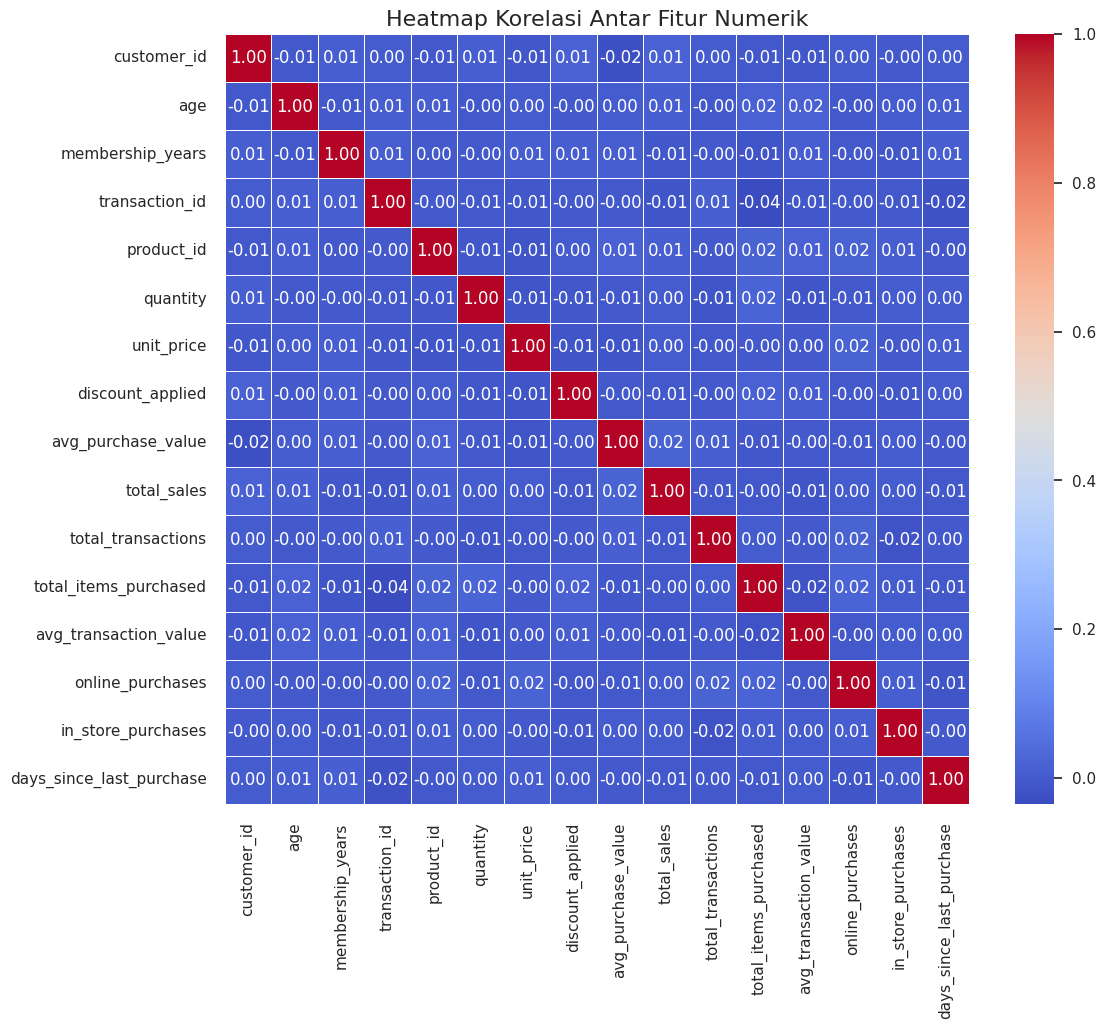

In [377]:
# Hitung matriks korelasi
corr_matrix = df[numeric_cols].corr()

# Buat heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,      # Tampilkan angka korelasi di tiap kotak
    cmap='coolwarm', # Gunakan skema warna 'coolwarm' (biru-merah)
    fmt=".2f",       # Format angka menjadi 2 desimal
    linewidths=0.5
)
plt.title('Heatmap Korelasi Antar Fitur Numerik', fontsize=16)
plt.show()

/tmp/ipython-input-2564224004.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', palette='viridis')


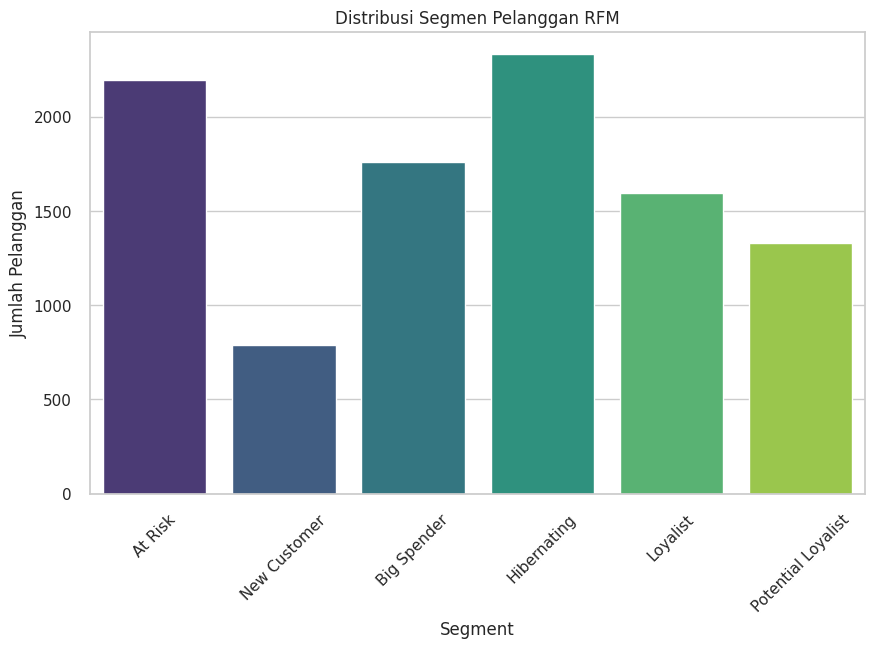

In [378]:
plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', palette='viridis')
plt.title("Distribusi Segmen Pelanggan RFM")
plt.xticks(rotation=45)
plt.ylabel("Jumlah Pelanggan")
plt.show()

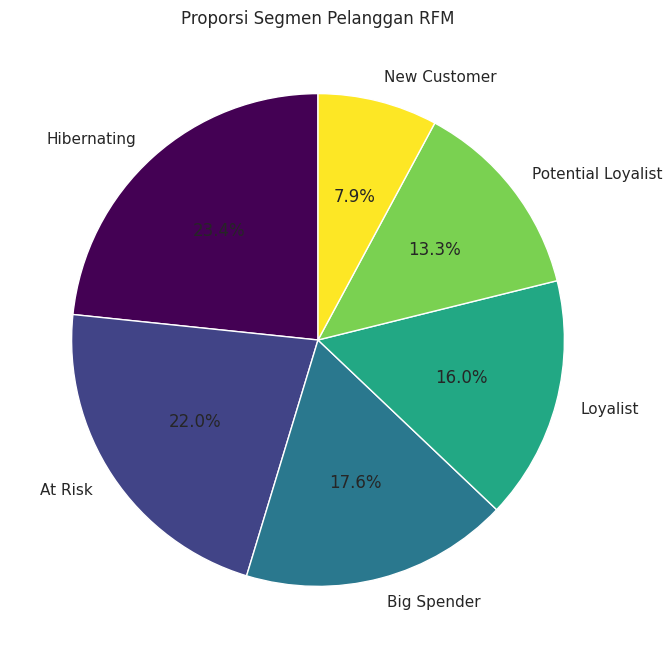

In [379]:
plt.figure(figsize=(8,8))
rfm['Segment'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.ylabel('')
plt.title("Proporsi Segmen Pelanggan RFM")
plt.show()

/tmp/ipython-input-1035124886.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Segment', y='Recency', palette='viridis')


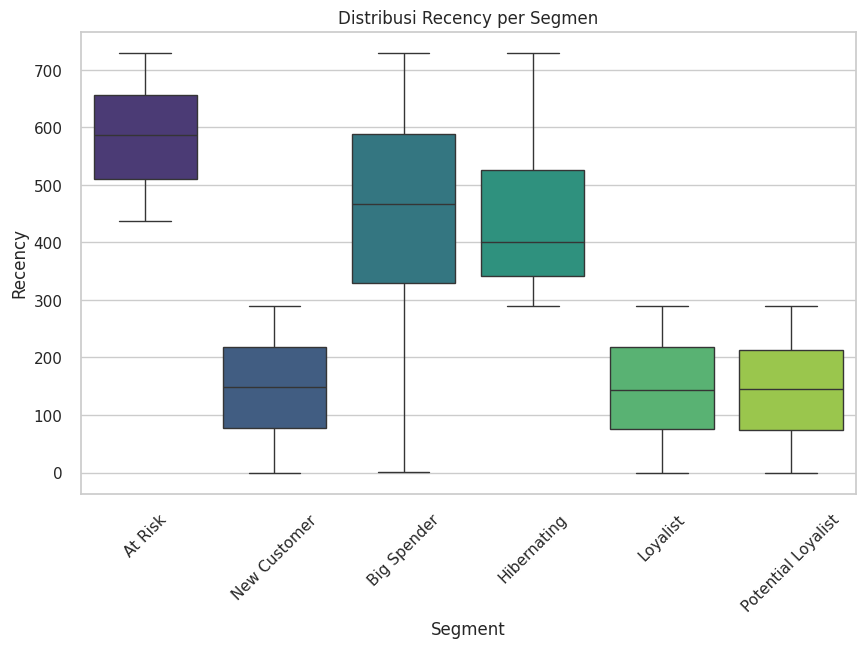

/tmp/ipython-input-1035124886.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Segment', y='Frequency', palette='viridis')


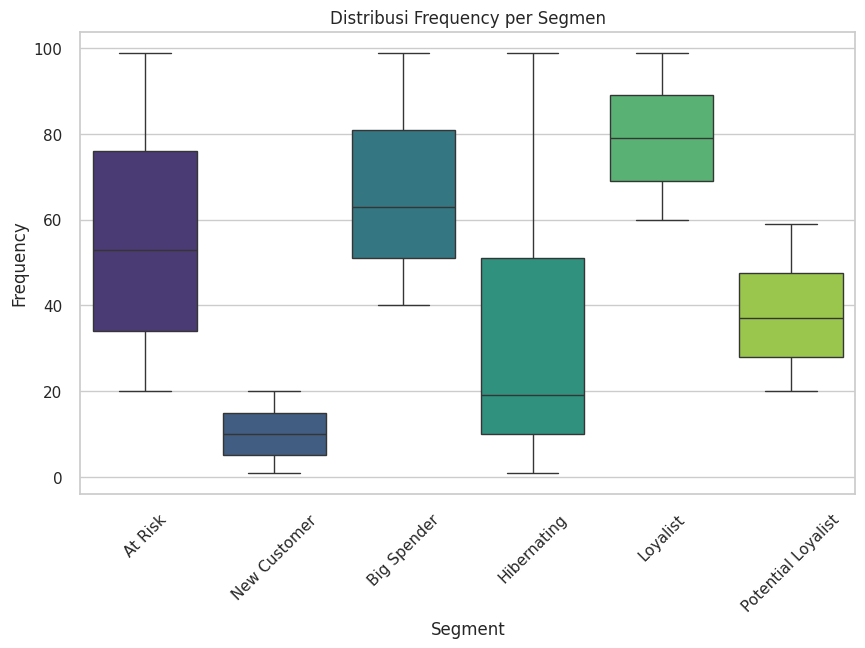

/tmp/ipython-input-1035124886.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=rfm, x='Segment', y='Monetary', palette='viridis')


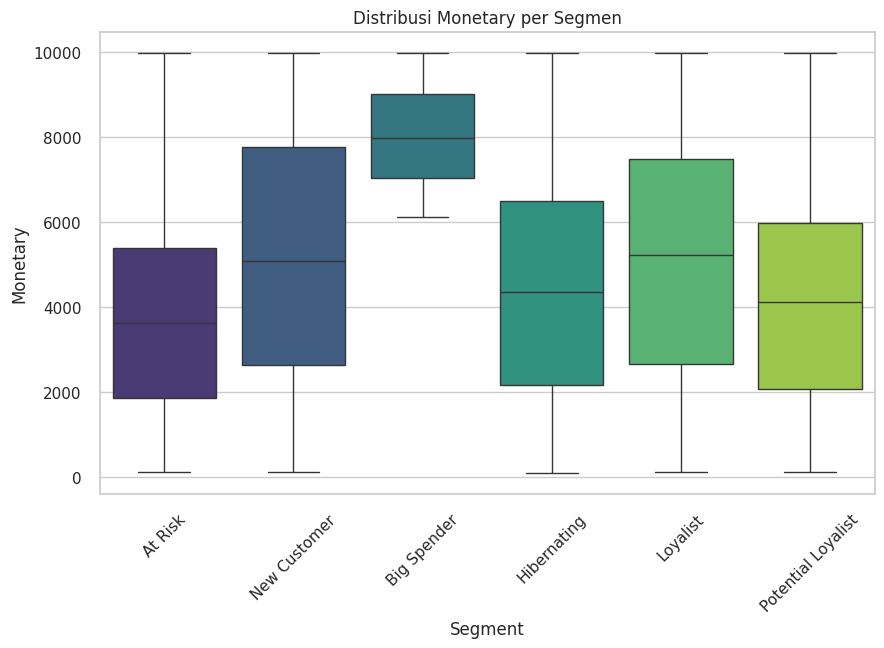

In [380]:
plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Recency', palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribusi Recency per Segmen")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Frequency', palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribusi Frequency per Segmen")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=rfm, x='Segment', y='Monetary', palette='viridis')
plt.xticks(rotation=45)
plt.title("Distribusi Monetary per Segmen")
plt.show()

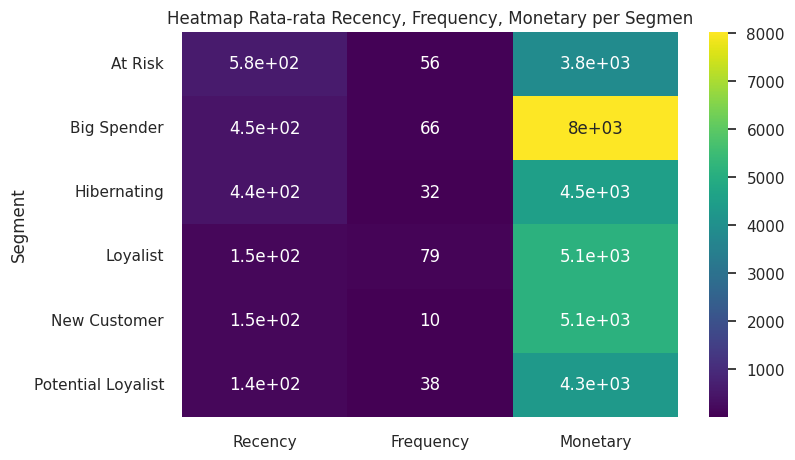

In [381]:
rfm_mean = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean()

plt.figure(figsize=(8,5))
sns.heatmap(rfm_mean, annot=True, cmap='viridis')
plt.title("Heatmap Rata-rata Recency, Frequency, Monetary per Segmen")
plt.show()

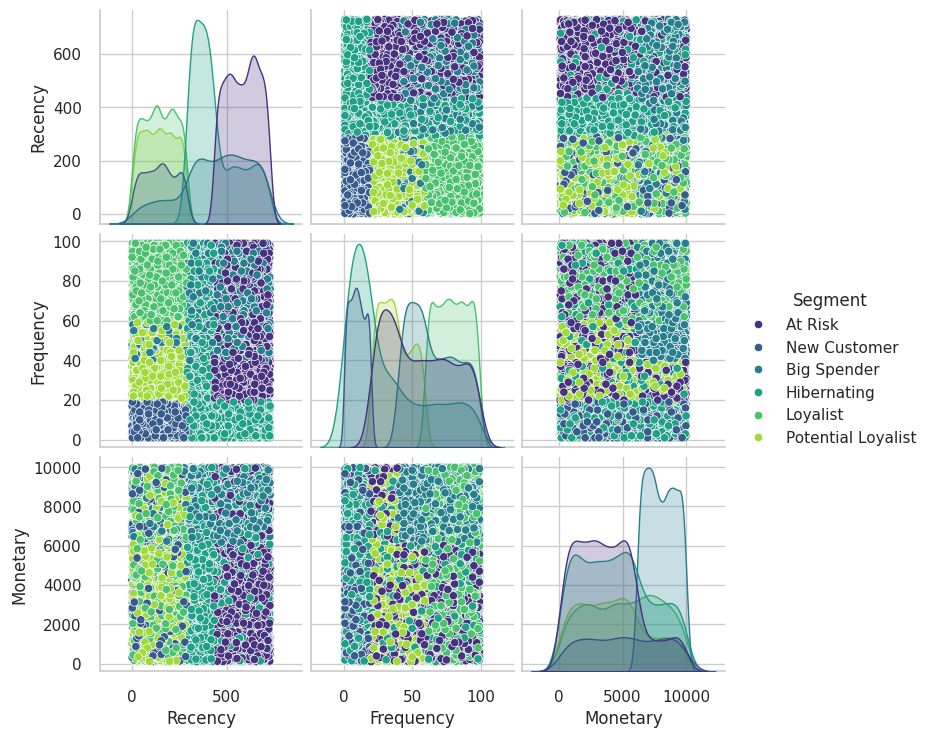

In [382]:
sns.pairplot(rfm[['Recency','Frequency','Monetary','Segment']], hue='Segment', palette='viridis')
plt.show()

📊 RFM Mean per Segmen:

                    Recency  Frequency  Monetary
Segment                                         
At Risk              584.43      55.64   3835.12
Big Spender          445.16      65.92   8027.06
Hibernating          440.74      32.23   4513.02
Loyalist             146.70      79.29   5126.99
New Customer         147.38      10.07   5131.48
Potential Loyalist   144.27      37.93   4302.63


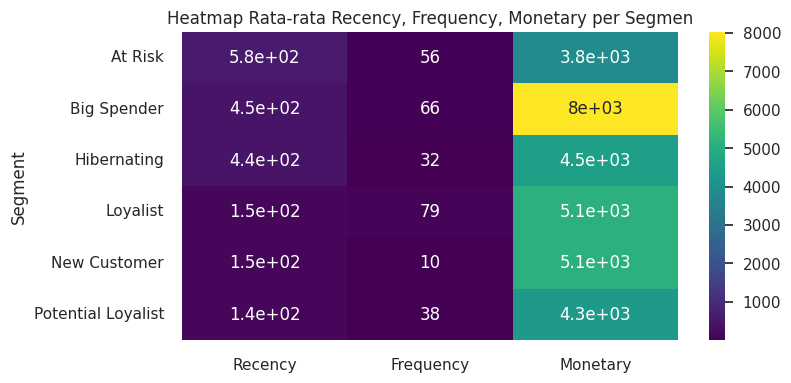

In [383]:
rfm_mean = rfm.groupby('Segment')[['Recency','Frequency','Monetary']].mean().round(2)

print("📊 RFM Mean per Segmen:\n")
print(rfm_mean)

plt.figure(figsize=(8,4))
sns.heatmap(rfm_mean, annot=True, cmap='viridis')
plt.title("Heatmap Rata-rata Recency, Frequency, Monetary per Segmen")
plt.show()

# Normalisasi

In [385]:
# 1. Drop identifier
features = rfm_full.drop(columns=['customer_id'])

# 2. Drop datetime columns
datetime_cols = features.select_dtypes(include=['datetime64']).columns
features = features.drop(columns=datetime_cols)

scaler = StandardScaler()
scaled_full = scaler.fit_transform(features)

rfm_scaled_df = pd.DataFrame(scaled_full, columns=features.columns)
print("Data setelah StandardScaler:")
rfm_scaled_df.head()

Data setelah StandardScaler:


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned
0,0.390449,0.671018,-1.586375,-0.710223,0.707107,-1.414214,-0.816594,-1.274692,0.402272,1.229871,-1.218304,-0.990842,-1.588107,0.011714,-1.220681,-0.714704,1.171988,-1.578852,1.723286,-0.446190,-1.331224,1.102184,0.438696,-1.586375,0.671018,0.803867,-0.574012,0.185400,1.278182,-1.355255,-1.014099
1,-1.617764,-1.463475,0.857800,1.412803,-1.414214,0.707107,0.406096,1.153755,1.128434,-1.232333,1.213684,-0.990842,-0.888716,-0.529050,-1.180134,0.694552,0.784938,1.108111,0.479575,-0.446190,0.459620,0.097023,-1.346073,0.857800,-1.463475,1.552842,-1.641120,-0.056537,-1.647318,1.486077,-1.014099
2,1.515618,0.810985,0.861146,-1.417899,0.707107,0.707107,-0.001467,-0.667580,-0.156315,-1.232333,-0.002310,-0.990842,0.160370,-0.021679,0.048407,1.399180,1.171988,-0.807160,0.686860,0.442989,-1.331224,-0.057682,0.438696,0.861146,0.810985,-0.784238,-1.394908,-1.162538,-0.149740,-1.155027,-1.014099
3,0.670554,-1.043575,1.057542,-0.710223,-1.414214,1.414214,-0.409030,-0.060468,-0.938336,-1.232333,-0.002310,-0.990842,-1.588107,1.256938,1.193773,1.399180,-1.150313,0.163805,-1.040517,-0.446190,-1.331224,-0.536690,0.438696,1.057542,-1.043575,-0.645539,-1.672011,0.012588,-0.080086,-1.336186,-1.014099
4,-0.862904,1.160902,-1.743288,0.705128,1.414214,-1.414214,0.406096,0.546644,0.625706,-1.232333,-0.002310,1.009243,0.859761,0.124896,0.354415,-1.419332,-0.376213,0.994516,-0.556851,1.332169,0.459620,-0.288682,1.331081,-1.743288,1.160902,0.082631,-0.094112,-0.056537,-0.254222,0.570748,0.986097


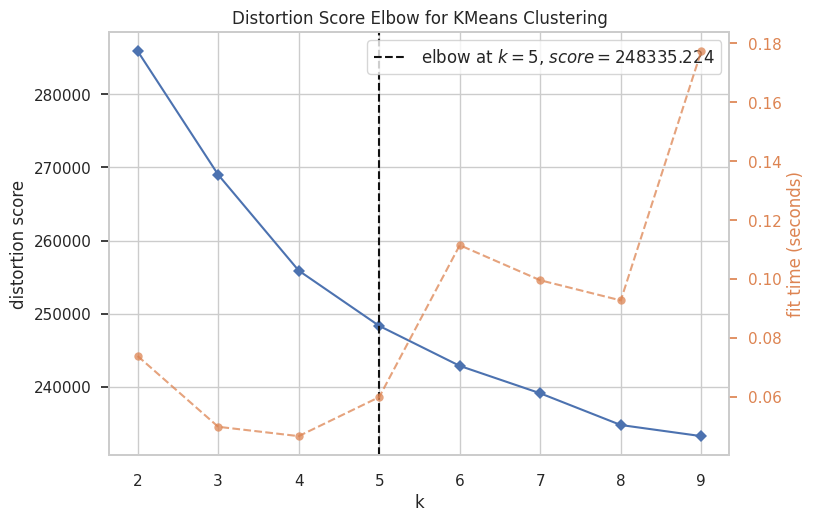

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [386]:
# Gunakan data scaled
X = rfm_scaled_df

# Model dasar KMeans
model = KMeans(random_state=42)

# Visualizer
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion')

visualizer.fit(X)
visualizer.show()

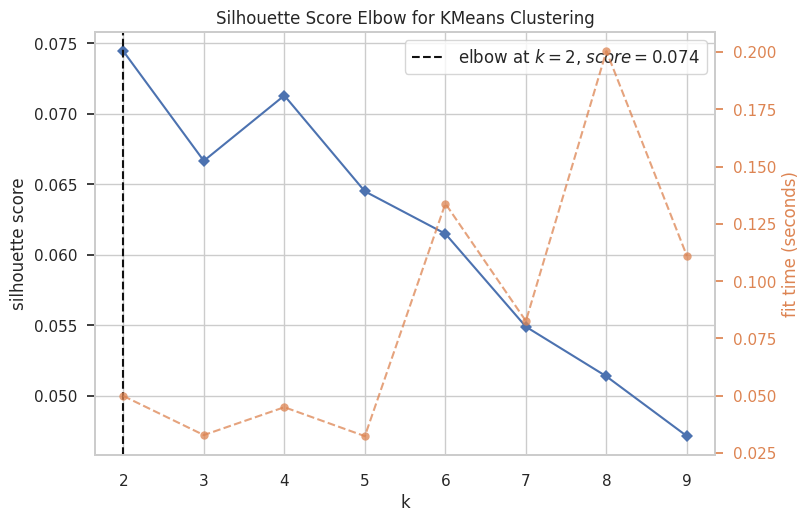

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [387]:
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X)
visualizer.show()

# Modelling

## Model 1

In [388]:
# K-Means dengan k=5
kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=50)
cluster_labels = kmeans_final.fit_predict(rfm_scaled_df)

# Simpan hasil cluster ke dataframe utama
rfm_full['Cluster'] = cluster_labels

# Lihat 10 sample data
rfm_full[['customer_id', 'Recency', 'Frequency', 'Monetary', 'Cluster']].head(10)

,customer_id,Recency,Frequency,Monetary,Cluster
0,1,446,69,563.16,1
1,2,23,8,7554.57,3
2,3,683,73,7564.14,0
3,4,505,20,8125.92,0
4,5,182,83,114.32,1
5,6,395,52,3372.17,1
6,7,657,58,1322.64,4
7,8,44,86,1716.65,1
8,9,592,88,1358.62,1
9,10,661,74,6757.70,0


In [389]:
# Hitung silhouette score
silhouette_k5 = silhouette_score(rfm_scaled_df, cluster_labels)
print("Silhouette Score (k=5):", silhouette_k5)

Silhouette Score (k=5): 0.06450269158039479


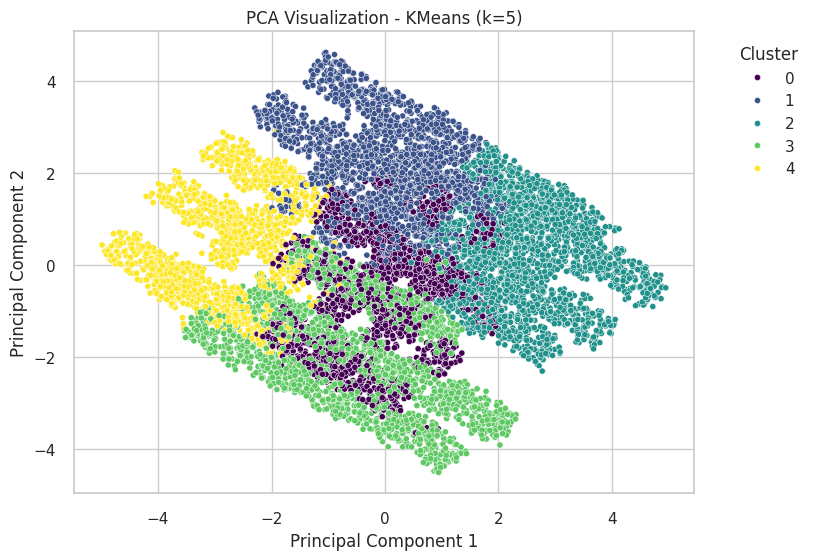

In [391]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

rfm_full['PC1'] = pca_result[:, 0]
rfm_full['PC2'] = pca_result[:, 1]

def plot_pca_clusters(df, cluster_col, title):
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x='PC1',
        y='PC2',
        hue=cluster_col,
        palette='viridis',
        s=20
    )
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_pca_clusters(rfm_full, 'Cluster', "PCA Visualization - KMeans (k=5)")

In [392]:
cluster_profile = rfm_full.groupby('Cluster').mean().round(2)
cluster_profile

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned,PC1,PC2
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4968.01,521.46,34.26,7527.67,1.93,2.23,4.20,8.35,1.15,49.37,1.00,1.02,0.50,4.49,496930.13,2020-07-27 23:57:51.617378048,5064.56,1.99,5.10,502.17,0.25,1.51,1.47,252.61,1.53,2021-07-02 18:34:28.419715584,7527.67,34.26,245.96,247.27,49.55,50.29,181.41,0.51,-0.10,-0.72
1,4911.00,402.73,78.10,2674.31,2.74,4.41,1.79,8.95,1.38,49.05,0.99,0.99,0.51,4.58,504876.61,2020-11-23 17:22:29.083293440,4988.30,2.03,4.95,505.22,0.25,1.55,1.44,254.83,1.52,2021-07-05 12:27:32.896485376,2674.31,78.10,255.25,252.96,50.26,49.61,182.97,0.51,0.03,2.16
2,5124.64,277.67,75.47,7499.12,3.59,4.29,4.21,12.09,1.92,48.41,1.00,1.03,0.47,4.56,500676.58,2021-03-28 19:03:55.957828608,5022.47,2.03,4.91,496.95,0.25,1.44,1.53,259.92,1.47,2021-07-02 00:48:52.225212928,7499.12,75.47,250.13,250.82,50.43,48.55,181.93,0.50,2.55,0.17
3,4989.15,145.04,27.82,4601.62,4.49,1.89,2.75,9.13,4.61,47.86,1.00,0.99,0.50,4.52,495581.57,2021-08-08 10:01:31.165725184,4947.20,2.02,4.98,502.25,0.25,1.51,1.54,254.91,1.51,2021-07-06 17:48:53.561205504,4601.62,27.82,252.36,258.91,48.09,49.30,182.08,0.50,-0.51,-1.93
4,4998.75,529.26,25.77,2590.82,1.87,1.80,1.75,5.41,1.12,49.56,1.03,0.97,0.50,4.56,501877.02,2020-07-20 05:03:27.842696448,4989.09,2.00,4.92,498.19,0.26,1.52,1.44,251.19,1.51,2021-06-27 16:50:25.106117376,2590.82,25.77,251.62,257.81,49.87,48.72,182.33,0.52,-2.78,0.39


In [393]:
print("Jumlah pelanggan per cluster:")
print(rfm_full['Cluster'].value_counts())

Jumlah pelanggan per cluster:
Cluster
2    2229
3    2124
1    2077
0    1968
4    1602
Name: count, dtype: int64


## Model 2

In [394]:
# Model GMM dengan 5 cluster
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X)

# Simpan hasil cluster
rfm_full['GMM_Cluster'] = gmm_labels

# Silhouette score
gmm_silhouette = silhouette_score(X, gmm_labels)
print("Silhouette Score GMM (k=5):", gmm_silhouette)

# Jumlah data per cluster
print("\nJumlah data per cluster:")
print(rfm_full['GMM_Cluster'].value_counts())

Silhouette Score GMM (k=5): 0.05432884373585158

Jumlah data per cluster:
GMM_Cluster
2    2532
0    2113
4    2000
1    1759
3    1596
Name: count, dtype: int64


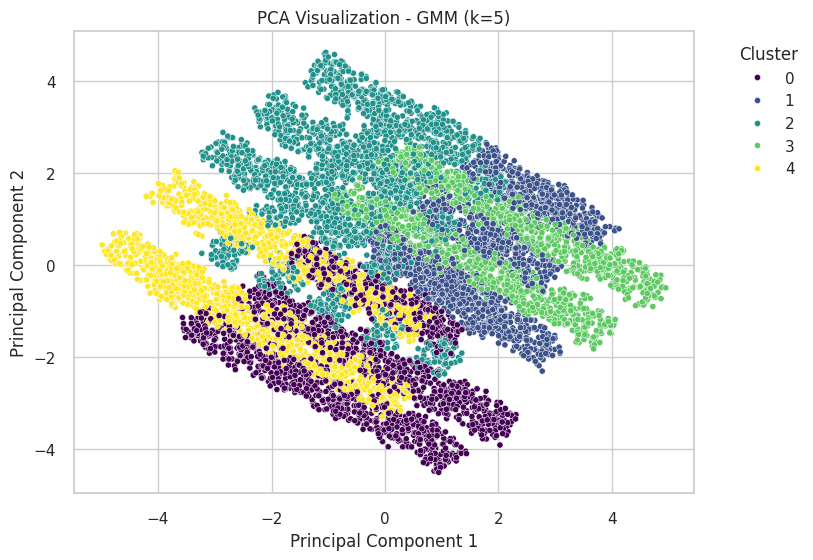

In [395]:
plot_pca_clusters(rfm_full, 'GMM_Cluster', "PCA Visualization - GMM (k=5)")

In [396]:
cluster_profile = rfm_full.groupby('GMM_Cluster').mean().round(2)
cluster_profile

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned,Cluster,PC1,PC2
GMM_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4981.40,145.43,27.57,4610.95,4.50,1.87,2.75,9.12,4.63,47.98,1.00,0.99,0.50,4.54,495401.88,2021-08-08 00:52:47.828679424,4950.37,2.02,4.99,501.73,0.25,1.51,1.54,254.93,1.52,2021-07-06 19:13:52.695693312,4610.95,27.57,252.39,258.65,48.11,49.34,181.76,0.50,2.99,-0.52,-1.95
1,5157.46,445.16,65.92,8027.06,2.45,3.82,4.49,10.75,1.00,48.84,0.98,1.03,0.48,4.53,495836.70,2020-10-12 07:16:31.515633664,5147.67,1.97,4.93,502.74,0.25,1.48,1.51,256.28,1.50,2021-07-01 15:38:31.497441792,8027.06,65.92,249.70,249.03,50.37,48.71,179.06,0.51,1.32,1.82,0.28
2,4916.53,487.30,63.77,3433.23,2.15,3.70,2.15,8.00,0.89,49.13,1.01,0.99,0.50,4.57,500381.65,2020-08-31 03:47:45.478673152,4989.70,2.02,4.98,503.39,0.25,1.54,1.46,256.57,1.50,2021-07-05 14:38:18.890205440,3433.23,63.77,251.79,253.07,50.13,49.85,183.19,0.52,1.49,-0.55,1.69
3,5064.20,146.70,79.29,5126.99,4.50,4.50,3.02,12.03,3.00,48.48,1.00,1.00,0.51,4.56,508382.59,2021-08-06 18:07:01.059523840,4941.20,2.05,4.94,493.82,0.26,1.44,1.48,256.64,1.50,2021-06-29 19:24:18.419799552,5126.99,79.29,249.59,254.19,50.33,48.72,183.35,0.48,1.63,2.06,0.43
4,4938.11,539.63,18.01,5135.36,1.80,1.39,3.01,6.20,1.21,49.46,1.01,1.01,0.49,4.50,500955.84,2020-07-09 19:53:16.218999808,4994.12,2.01,4.99,501.49,0.25,1.52,1.45,250.46,1.52,2021-06-30 11:01:53.856000000,5135.36,18.01,251.22,251.51,49.43,49.54,182.95,0.51,2.15,-2.00,-0.67


## Model 3

In [397]:
# Model hierarchical clustering
agg = AgglomerativeClustering(n_clusters=5, linkage='ward')
agg_labels = agg.fit_predict(X)

# Simpan hasil cluster
rfm_full['Agg_Cluster'] = agg_labels

# Silhouette score
agg_silhouette = silhouette_score(X, agg_labels)
print("Silhouette Score Agglomerative (k=5):", agg_silhouette)

# Jumlah data per cluster
print("\nJumlah data per cluster:")
print(rfm_full['Agg_Cluster'].value_counts())

Silhouette Score Agglomerative (k=5): 0.040445588455006586

Jumlah data per cluster:
Agg_Cluster
1    2475
2    2409
0    2373
3    1747
4     996
Name: count, dtype: int64


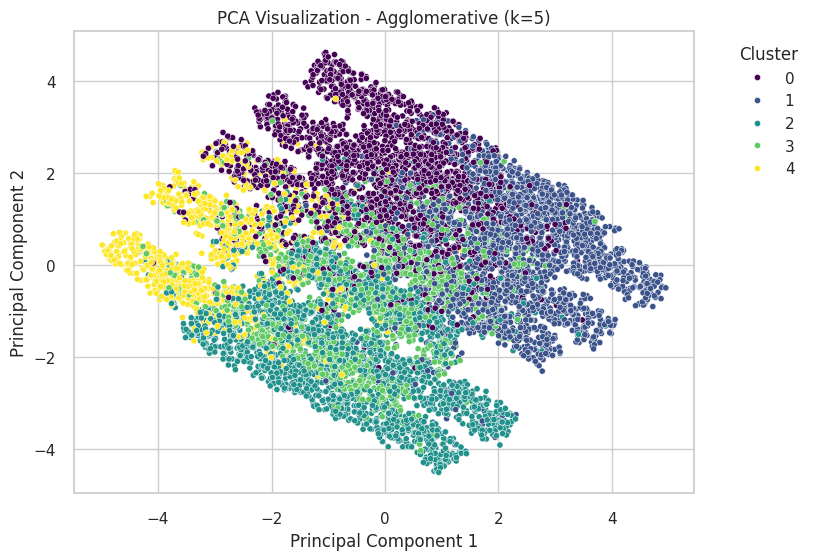

In [398]:
plot_pca_clusters(rfm_full, 'Agg_Cluster', "PCA Visualization - Agglomerative (k=5)")

In [399]:
cluster_profile = rfm_full.groupby('Agg_Cluster').mean().round(2)
cluster_profile

,customer_id,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned,Cluster,PC1,PC2,GMM_Cluster
Agg_Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4962.40,416.66,72.20,2914.17,2.65,4.11,1.92,8.67,1.34,48.41,0.98,0.97,0.53,4.55,502458.59,2020-11-09 19:30:38.200590080,4955.80,2.03,5.14,502.66,0.25,1.55,1.45,255.52,1.57,2021-07-04 11:59:33.422250240,2914.17,72.20,249.69,254.17,50.06,49.90,185.17,0.53,1.45,-0.17,1.89,2.21
1,5046.37,317.02,72.72,7360.48,3.32,4.15,4.13,11.60,1.82,49.30,1.01,1.04,0.47,4.59,511361.23,2021-02-17 10:22:20.673535232,5009.12,1.99,4.90,496.64,0.25,1.42,1.52,260.12,1.48,2021-07-03 12:47:56.538181888,7360.48,72.72,251.69,252.00,50.28,49.11,181.41,0.52,1.67,2.22,0.23,1.84
2,5014.67,177.60,28.46,4638.10,4.27,1.93,2.77,8.97,4.13,47.83,0.98,1.01,0.50,4.58,486323.47,2021-07-06 20:33:03.572851968,5036.57,2.02,4.98,511.52,0.25,1.51,1.54,251.13,1.49,2021-07-05 10:11:49.837691904,4638.10,28.46,255.67,256.69,48.16,50.01,178.49,0.50,2.76,-0.57,-1.72,0.57
3,5023.32,525.92,31.12,7041.01,1.91,2.07,3.95,7.93,1.18,49.65,1.01,1.00,0.49,4.46,500530.44,2020-07-23 13:01:27.073268480,5050.30,2.06,4.89,507.16,0.25,1.51,1.48,255.41,1.52,2021-06-28 05:54:12.354894080,7041.01,31.12,246.03,237.50,49.93,47.66,183.34,0.49,0.85,-0.48,-0.70,2.91
4,4902.99,519.67,24.11,2412.15,1.94,1.71,1.67,5.32,1.31,49.33,1.09,0.95,0.49,4.47,497273.50,2020-07-29 18:58:46.082329344,4929.27,1.92,4.84,471.82,0.26,1.54,1.40,249.30,1.47,2021-07-02 16:17:01.008032000,2412.15,24.11,250.68,275.01,50.09,49.49,183.44,0.47,3.61,-2.90,0.31,3.37


In [400]:
results = pd.DataFrame({
    'Model': ['KMeans', 'GMM', 'Agglomerative'],
    'Silhouette Score': [silhouette_k5, gmm_silhouette, agg_silhouette]
})

print("\nPERBANDINGAN MODEL CLUSTERING")
print(results)


PERBANDINGAN MODEL CLUSTERING
           Model  Silhouette Score
0         KMeans          0.064503
1            GMM          0.054329
2  Agglomerative          0.040446


# Interpretation

In [401]:
def interpret_numeric(df, cluster_col):
    numeric_cols = df.select_dtypes(include=np.number).columns
    numeric_cols = numeric_cols.drop(cluster_col)

    summary = df.groupby(cluster_col)[numeric_cols].agg(['mean','median','std','min','max','count']).round(2)
    return summary

def interpret_categorical(df, cluster_col):
    cat_cols = df.select_dtypes(include=['object','category']).columns

    results = {}
    for col in cat_cols:
        if col in df.columns:
            mode_table = df.groupby(cluster_col)[col].agg(lambda x: x.value_counts(normalize=True).head(3))
            results[col] = mode_table

    return results

## Interpretasi Dataframe Hasil Modelling

In [402]:
print("=== NUMERIC FEATURES (KMeans) ===")
display(interpret_numeric(rfm_full, 'Cluster'))

print("\n=== CATEGORICAL FEATURES (KMeans) ===")
cat_result_kmeans = interpret_categorical(rfm_full, 'Cluster')
for col, table in cat_result_kmeans.items():
    print(f"\n--- {col} ---")
    display(table)

=== NUMERIC FEATURES (KMeans) ===


customer_id                                   Recency                 \
               mean  median      std min    max count    mean median     std   
Cluster                                                                        
0           4968.01  5004.0  2884.19   3   9998  1968  521.46  529.0  128.35   
1           4911.00  4900.0  2900.13   1   9992  2077  402.73  411.0  199.87   
2           5124.64  5103.0  2869.72  11  10000  2229  277.67  248.0  183.04   
3           4989.15  4957.5  2930.02   2   9991  2124  145.04  146.0   84.00   
4           4998.75  4972.0  2836.64   7   9999  1602  529.26  538.0  123.98   

                        Frequency                             Monetary  \
         min  max count      mean median    std min max count     mean   
Cluster                                                                  
0        209  730  1968     34.26   34.5  19.07   1  79  1968  7527.67   
1          0  730  2077     78.10   78.0  12.99  43  99  2077  2674.31   
2          0  729  2229     75.47   77.0  15.36  40  99  2229  7499.12   
3          0  324  2124     27.82   27.0  16.66   1  66  2124  4601.62   
4        249  730  1602     25.77   24.0  16.34   1  60  1602  2590.82   

                                                  R_Score                   \
          median      std      min      max count    mean median   std min   
Cluster                                                                      
0        7500.35  1496.42  4281.74  9996.14  1968    1.93    2.0  0.82   1   
1        2605.89  1572.88   100.02  6131.97  2077    2.74    3.0  1.34   1   
2        7521.02  1517.13  4013.15  9999.15  2229    3.59    4.0  1.23   1   
3        4468.92  2753.45   102.48  9992.79  2124    4.49    4.0  0.51   3   
4        2527.44  1539.38   100.70  6105.65  1602    1.87    2.0  0.79   1   

                  F_Score                            M_Score                   \
        max count    mean median   std min max count    mean median   std min   
Cluster                                                                         
0         4  1968    2.23    2.0  0.95   1   4  1968    4.20    4.0  0.75   3   
1         5  2077    4.41    4.0  0.61   3   5  2077    1.79    2.0  0.75   1   
2         5  2229    4.29    4.0  0.73   3   5  2229    4.21    4.0  0.74   2   
3         5  2124    1.89    2.0  0.79   1   4  2124    2.75    3.0  1.36   1   
4         4  1602    1.80    2.0  0.79   1   4  1602    1.75    2.0  0.72   1   

                  RFM_Score                            Segment               \
        max count      mean median   std min max count    mean median   std   
Cluster                                                                       
0         5  1968      8.35    8.0  1.19   6  11  1968    1.15    1.0  0.83   
1         4  2077      8.95    9.0  1.47   6  12  2077    1.38    2.0  1.31   
2         5  2229     12.09   12.0  1.26   9  15  2229    1.92    1.0  0.98   
3         5  2124      9.13    9.0  1.48   6  12  2124    4.61    5.0  0.52   
4         3  1602      5.41    5.0  1.11   3   8  1602    1.12    2.0  1.00   

                         age                             gender               \
        min max count   mean median    std min max count   mean median   std   
Cluster                                                                        
0         0   4  1968  49.37   49.0  18.02  18  79  1968   1.00    1.0  0.81   
1         0   3  2077  49.05   49.0  17.91  18  79  2077   0.99    1.0  0.82   
2         1   3  2229  48.41   48.0  17.66  18  79  2229   1.00    1.0  0.81   
3         2   5  2124  47.86   47.0  17.98  18  79  2124   1.00    1.0  0.81   
4         0   4  1602  49.56   50.0  17.95  18  79  1602   1.03    1.0  0.83   

                      income_bracket                             \
        min max count           mean median   std min max count   
Cluster                                                           
0         0   2  1968    


=== CATEGORICAL FEATURES (KMeans) ===


In [403]:
print("=== NUMERIC FEATURES (GMM) ===")
display(interpret_numeric(rfm_full, 'GMM_Cluster'))

print("\n=== CATEGORICAL FEATURES (GMM) ===")
cat_result_gmm = interpret_categorical(rfm_full, 'GMM_Cluster')
for col, table in cat_result_gmm.items():
    print(f"\n--- {col} ---")
    display(table)

=== NUMERIC FEATURES (GMM) ===


customer_id                                   Recency         \
                   mean  median      std min    max count    mean median   
GMM_Cluster                                                                
0               4981.40  4946.0  2928.44   2   9991  2113  145.43  147.0   
1               5157.46  5285.0  2885.27   3  10000  1759  445.16  467.0   
2               4916.53  4889.5  2857.41   1   9994  2532  487.30  469.0   
3               5064.20  5026.5  2898.95   5   9996  1596  146.70  144.0   
4               4938.11  4912.0  2867.84   4   9999  2000  539.63  546.0   

                                    Frequency                              \
                std  min  max count      mean median    std min max count   
GMM_Cluster                                                                 
0             83.53    0  289  2113     27.57   27.0  16.54   1  59  2113   
1            181.85    1  730  1759     65.92   63.0  17.41  40  99  1759   
2            132.14  290  730  2532     63.77   65.0  21.64  20  99  2532   
3             83.56    0  289  1596     79.29   79.0  11.60  60  99  1596   
4            117.05  290  730  2000     18.01   17.0  11.23   1  40  2000   

            Monetary                                           R_Score         \
                mean   median      std      min      max count    mean median   
GMM_Cluster                                                                     
0            4610.95  4488.63  2776.27   102.48  9992.79  2113    4.50    4.0   
1            8027.06  7993.25  1140.64  6110.97  9999.15  1759    2.45    2.0   
2            3433.23  3332.58  2101.47   100.02  9994.57  2532    2.15    2.0   
3            5126.99  5225.90  2807.74   114.00  9997.06  1596    4.50    5.0   
4            5135.36  5236.27  2906.76   100.70  9996.14  2000    1.80    2.0   

                                F_Score                            M_Score  \
              std min max count    mean median   std min max count    mean   
GMM_Cluster                                                                  
0            0.50   4   5  2113    1.87    2.0  0.78   1   3  2113    2.75   
1            1.21   1   5  1759    3.82    4.0  0.83   3   5  1759    4.49   
2            0.84   1   3  2532    3.70    4.0  1.05   2   5  2532    2.15   
3            0.50   4   5  1596    4.50    4.0  0.50   4   5  1596    3.02   
4            0.74   1   3  2000    1.39    1.0  0.49   1   2  2000    3.01   

                                       RFM_Score                             \
            median   std min max count      mean median   std min max count   
GMM_Cluster                                                                   
0              3.0  1.37   1   5  2113      9.12    9.0  1.48   6  12  2113   
1              4.0  0.50   4   5  1759     10.75   11.0  1.30   8  13  1759   
2              2.0  1.01   1   5  2532      8.00    8.0  1.42   5  11  2532   
3              3.0  1.39   1   5  1596     12.03   12.0  1.57   9  15  1596   
4              3.0  1.43   1   5  2000      6.20    6.0  1.63   3   9  2000   

            Segment                               age                        \
               mean median   std min max count   mean median    std min max   
GMM_Cluster                                                                   
0              4.63    5.0  0.48   4   5  2113  47.98   47.0  17.99  18  79   
1              1.00    1.0  0.00   1   1  1759  48.84   49.0  17.81  18  79   
2              0.89    0.0  0.99   0   2  2532  49.13   49.0  17.89  18  79   
3              3.00    3.0  0.00   3   3  1596  48.48   48.0  17.91  18  79   
4              1.21    2.0  0.98   0   2  2000  49.46   50.0  17.88  18  79   

                  gender                            income_bracket         \
            count   mean median   std min max count           mean median   
GMM_Cluster                                                                 
0            21


=== CATEGORICAL FEATURES (GMM) ===


In [404]:
print("=== NUMERIC FEATURES (Agglomerative) ===")
display(interpret_numeric(rfm_full, 'Agg_Cluster'))

print("\n=== CATEGORICAL FEATURES (Agglomerative) ===")
cat_result_agg = interpret_categorical(rfm_full, 'Agg_Cluster')
for col, table in cat_result_agg.items():
    print(f"\n--- {col} ---")
    display(table)

=== NUMERIC FEATURES (Agglomerative) ===


customer_id                                   Recency         \
                   mean  median      std min    max count    mean median   
Agg_Cluster                                                                
0               4962.40  4900.0  2926.44   1   9992  2373  416.66  443.0   
1               5046.37  5095.0  2855.42   3   9998  2475  317.02  299.0   
2               5014.67  4967.0  2914.11   2  10000  2409  177.60  165.0   
3               5023.32  5047.0  2865.40   4   9994  1747  525.92  535.0   
4               4902.99  4846.5  2843.30  22   9999   996  519.67  531.0   

                                    Frequency                              \
                std  min  max count      mean median    std min max count   
Agg_Cluster                                                                 
0            206.87    0  730  2373     72.20   74.0  18.06   5  99  2373   
1            197.81    0  730  2475     72.72   75.0  17.62   7  99  2475   
2            115.69    0  727  2409     28.46   27.0  18.47   1  99  2409   
3            129.84  110  730  1747     31.12   29.0  19.95   1  99  1747   
4            134.55  110  730   996     24.11   22.0  15.97   1  83   996   

            Monetary                                          R_Score         \
                mean   median      std     min      max count    mean median   
Agg_Cluster                                                                    
0            2914.17  2730.92  1846.43  100.02  9532.88  2373    2.65    2.0   
1            7360.48  7499.45  1742.98  903.07  9999.15  2475    3.32    3.0   
2            4638.10  4505.02  2768.28  102.48  9994.57  2409    4.27    4.0   
3            7041.01  7283.92  1980.17  330.04  9996.14  1747    1.91    2.0   
4            2412.15  2130.51  1629.71  100.70  9608.51   996    1.94    2.0   

                                F_Score                            M_Score  \
              std min max count    mean median   std min max count    mean   
Agg_Cluster                                                                  
0            1.39   1   5  2373    4.11    4.0  0.89   1   5  2373    1.92   
1            1.33   1   5  2475    4.15    4.0  0.85   1   5  2475    4.13   
2            0.76   1   5  2409    1.93    2.0  0.90   1   5  2409    2.77   
3            0.85   1   5  1747    2.07    2.0  0.98   1   5  1747    3.95   
4            0.87   1   5   996    1.71    2.0  0.78   1   5   996    1.67   

                                       RFM_Score                             \
            median   std min max count      mean median   std min max count   
Agg_Cluster                                                                   
0              2.0  0.90   1   5  2373      8.67    9.0  1.86   4  14  2373   
1              4.0  0.87   1   5  2475     11.60   12.0  1.63   7  15  2475   
2              3.0  1.37   1   5  2409      8.97    9.0  1.64   4  14  2409   
3              4.0  1.00   1   5  1747      7.93    8.0  1.64   3  13  1747   
4              2.0  0.76   1   5   996      5.32    5.0  1.36   3  11   996   

            Segment                               age                        \
               mean median   std min max count   mean median    std min max   
Agg_Cluster                                                                   
0              1.34    1.0  1.44   0   5  2373  48.41   48.0  17.96  18  79   
1              1.82    1.0  1.10   0   5  2475  49.30   49.0  17.76  18  79   
2              4.13    4.0  1.11   0   5  2409  47.83   47.0  17.91  18  79   
3              1.18    1.0  0.91   0   5  1747  49.65   50.0  17.87  18  79   
4              1.31    2.0  1.11   0   5   996  49.33   50.0  18.07  18  79   

                  gender                            income_bracket         \
            count   mean median   std min max count           mean median   
Agg_Cluster                                                                 
0            2373   0.9


=== CATEGORICAL FEATURES (Agglomerative) ===


## Interpretasi Dataframe Gabungan Sebelum Modelling

In [405]:
df_inverse = df.merge(
    rfm_full[['customer_id', 'Recency', 'Frequency', 'Monetary', 'Cluster']],
    on='customer_id',
    how='left'
)
df_inverse.head()


,customer_id,age,gender,income_bracket,loyalty_program,membership_years,transaction_id,transaction_date,product_id,product_category,quantity,unit_price,discount_applied,payment_method,store_location,avg_purchase_value,purchase_frequency,last_purchase_date,total_sales,total_transactions,total_items_purchased,avg_transaction_value,online_purchases,in_store_purchases,days_since_last_purchase,churned,Recency,Frequency,Monetary,Cluster
0,1,56,Other,High,No,0,503290,2020-10-11 10:08:52,1480,Electronics,8,49.72,0.50,Credit Card,Location A,411.13,Weekly,2021-09-11 04:22:38,563.16,69,367,171.83,55,86,40,No,446,69,563.16,1
1,2,69,Female,Medium,No,2,347796,2021-12-08 01:07:40,1597,Groceries,7,817.76,0.32,Credit Card,Location C,268.71,Daily,2021-05-16 12:01:16,7554.57,8,475,20.18,48,2,338,No,23,8,7554.57,3
2,3,46,Female,Low,No,5,493688,2020-02-17 09:40:48,5142,Toys,8,270.30,0.35,Debit Card,Location A,246.79,Weekly,2021-02-07 16:47:48,7564.14,73,138,55.17,16,45,61,No,683,73,7564.14,0
3,4,32,Female,Low,No,0,861348,2020-08-13 00:43:14,8447,Toys,2,547.84,0.10,Credit Card,Location A,178.92,Weekly,2021-12-30 23:48:26,8125.92,20,158,15.79,50,47,42,No,505,20,8125.92,0
4,5,60,Female,Low,Yes,7,535835,2021-07-02 11:59:03,6025,Clothing,4,785.29,0.17,Mobile Payment,Location C,214.06,Yearly,2021-11-02 11:48:25,114.32,83,263,240.03,48,42,242,Yes,182,83,114.32,1


In [406]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_display = df_inverse.copy()

cat_cols = df_display.select_dtypes(include=['object','category']).columns.tolist()
cat_cols = [c for c in cat_cols if c != 'Cluster']

for col in cat_cols:
    print(f"\n=== Proporsi kategori untuk kolom: {col} ===")
    prop = df_display.groupby('Cluster')[col].value_counts(normalize=True).unstack(fill_value=0)
    display(prop.style.format("{:.2%}").background_gradient(axis=1))


=== Proporsi kategori untuk kolom: gender ===


gender,Female,Male,Other
Cluster,,,
0,32.62%,35.21%,32.16%
1,33.85%,33.32%,32.84%
2,32.48%,34.77%,32.75%
3,32.72%,34.98%,32.30%
4,33.08%,31.15%,35.77%



=== Proporsi kategori untuk kolom: income_bracket ===


income_bracket,High,Low,Medium
Cluster,,,
0,32.67%,32.22%,35.11%
1,34.71%,31.58%,33.70%
2,31.90%,33.56%,34.54%
3,34.32%,32.53%,33.15%
4,35.46%,31.71%,32.83%



=== Proporsi kategori untuk kolom: loyalty_program ===


loyalty_program,No,Yes
Cluster,,
0,50.00%,50.00%
1,48.82%,51.18%
2,53.12%,46.88%
3,49.91%,50.09%
4,50.19%,49.81%



=== Proporsi kategori untuk kolom: product_category ===


product_category,Clothing,Electronics,Furniture,Groceries,Toys
Cluster,,,,,
0,20.53%,20.33%,19.66%,19.00%,20.48%
1,20.65%,19.21%,18.34%,20.41%,21.38%
2,19.07%,20.14%,20.32%,19.83%,20.64%
3,19.54%,18.97%,21.28%,19.87%,20.34%
4,19.85%,19.98%,20.29%,20.10%,19.79%



=== Proporsi kategori untuk kolom: payment_method ===


payment_method,Cash,Credit Card,Debit Card,Mobile Payment
Cluster,,,,
0,25.41%,24.64%,23.68%,26.27%
1,24.27%,23.11%,26.29%,26.34%
2,27.46%,24.50%,25.08%,22.97%
3,24.62%,25.05%,25.28%,25.05%
4,24.91%,24.91%,23.47%,26.72%



=== Proporsi kategori untuk kolom: store_location ===


store_location,Location A,Location B,Location C,Location D
Cluster,,,,
0,25.61%,25.15%,25.66%,23.58%
1,27.15%,25.04%,24.60%,23.21%
2,23.60%,25.71%,25.12%,25.57%
3,23.78%,25.28%,24.11%,26.84%
4,27.03%,24.91%,25.03%,23.03%



=== Proporsi kategori untuk kolom: purchase_frequency ===


purchase_frequency,Daily,Monthly,Weekly,Yearly
Cluster,,,,
0,24.09%,24.54%,26.12%,25.25%
1,24.55%,24.03%,26.05%,25.37%
2,25.71%,25.12%,25.21%,23.96%
3,25.33%,24.29%,24.01%,26.37%
4,25.34%,23.97%,25.09%,25.59%



=== Proporsi kategori untuk kolom: churned ===


churned,No,Yes
Cluster,,
0,48.88%,51.12%
1,49.01%,50.99%
2,50.34%,49.66%
3,49.62%,50.38%
4,48.31%,51.69%


In [407]:
num_cols = df_inverse.select_dtypes(include=['int64','float64']).columns
num_cols = [col for col in num_cols if col not in ['Cluster']]

df_inverse.groupby('Cluster')[num_cols].agg(['mean','median','std','min','max']).round(2)

customer_id                                age                        \
               mean  median      std min    max   mean median    std min max   
Cluster                                                                        
0           4968.01  5004.0  2884.19   3   9998  49.37   49.0  18.02  18  79   
1           4911.00  4900.0  2900.13   1   9992  49.05   49.0  17.91  18  79   
2           5124.64  5103.0  2869.72  11  10000  48.41   48.0  17.66  18  79   
3           4989.15  4957.5  2930.02   2   9991  47.86   47.0  17.98  18  79   
4           4998.75  4972.0  2836.64   7   9999  49.56   50.0  17.95  18  79   

        membership_years                      transaction_id            \
                    mean median   std min max           mean    median   
Cluster                                                                  
0                   4.49    5.0  2.89   0   9      496930.13  492615.5   
1                   4.58    5.0  2.83   0   9      504876.61  499028.0   
2                   4.56    5.0  2.88   0   9      500676.58  495329.0   
3                   4.52    5.0  2.86   0   9      495581.57  491558.5   
4                   4.56    5.0  2.83   0   9      501877.02  509791.5   

                                 product_id                             \
               std   min     max       mean  median      std min   max   
Cluster                                                                  
0        289249.11   515  999087    5064.56  5016.5  2863.29   5  9992   
1        287337.26   528  999955    4988.30  4996.0  2924.47   1  9995   
2        287099.29   182  999938    5022.47  4965.0  2858.68   7  9997   
3        287310.64     2  999942    4947.20  5037.0  2888.75   1  9995   
4        286966.90  1345  999744    4989.09  5054.0  2897.67   3  9986   

        quantity                      unit_price                        \
            mean median   std min max       mean  median     std   min   
Cluster                                                                  
0           5.10    5.0  2.61   1   9     502.17  506.11  280.67  1.54   
1           4.95    5.0  2.57   1   9     505.22  510.84  285.46  1.84   
2           4.91    5.0  2.57   1   9     496.95  499.23  288.09  2.04   
3           4.98    5.0  2.57   1   9     502.25  504.16  286.63  1.40   
4           4.92    5.0  2.61   1   9     498.19  508.32  288.76  1.08   

                discount_applied                        avg_purchase_value  \
            max             mean median   std  min  max               mean   
Cluster                                                                      
0        999.93             0.25   0.25  0.14  0.0  0.5             252.61   
1        999.85             0.25   0.25  0.14  0.0  0.5             254.83   
2        999.89             0.25   0.26  0.15  0.0  0.5             259.92   
3        999.58             0.25   0.25  0.14  0.0  0.5             254.91   
4        998.86             0.26   0.26  0.14  0.0  0.5             251.19   

                                       total_sales                             \
         median     std    min     max        mean   median      std      min   
Cluster                                                                         
0        249.20  144.26  10.06  499.96     7527.67  7500.35  1496.42  4281.74   
1        253.75  139.81  10.01  499.16     2674.31  2605.89  1572.88   100.02   
2        261.94  141.09  10.15  499.98     7499.12  7521.02  1517.13  4013.15   
3        253.11  140.42  10.11  499.95     4601.62  4468.92  2753.45   102.48   
4        250.40  143.44  10.07  499.40     2590.82  2527.44  1539.38   100.70   

                 total_transactions                        \
             max               mean median    std min max   
Cluster                                                     
0        9996.14              34.26   34.5  19.07   1  79   
1        6131.97              78.10   78.0  12.99  43  99   
2        